# Time Split + Naive Baselines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    "../data/processed/hourly_energy.csv",
    parse_dates=["datetime"]
)

df = df.sort_values("datetime").set_index("datetime")
y = df["Global_active_power"].copy()

y.head(), y.shape

(datetime
 2006-12-16 17:00:00    4.2229
 2006-12-16 18:00:00    3.6322
 2006-12-16 19:00:00    3.4002
 2006-12-16 20:00:00    3.2686
 2006-12-16 21:00:00    3.0565
 Name: Global_active_power, dtype: float64,
 (34589,))

### Time-Based Splits

In [2]:
n = len(y)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

y_train = y.iloc[:train_end]
y_val   = y.iloc[train_end:val_end]
y_test  = y.iloc[val_end:]

len(y_train), len(y_val), len(y_test)

(24212, 5188, 5189)

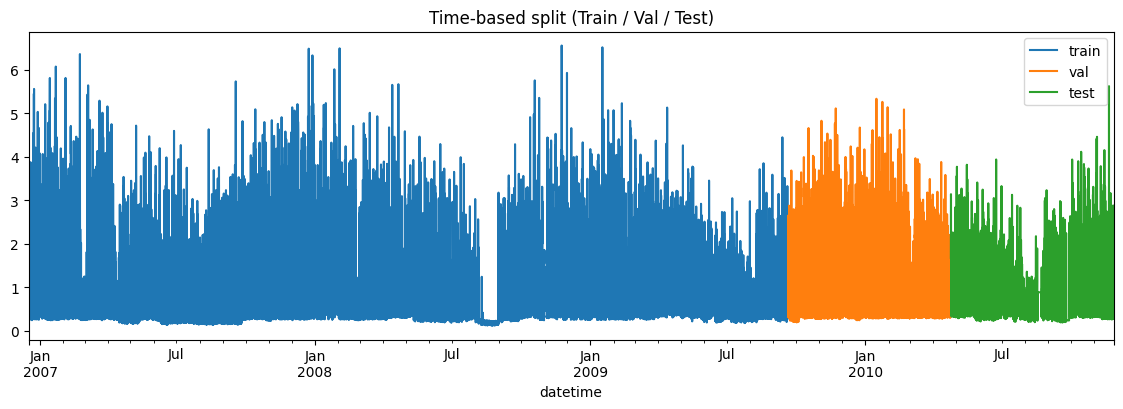

In [3]:
# quick check plot 
plt.figure(figsize=(14,4))
y_train.plot(label="train")
y_val.plot(label="val")
y_test.plot(label="test")
plt.title("Time-based split (Train / Val / Test)")
plt.legend()
plt.show()

### Define Metrics Functions

In [4]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

### Baseline 1: Naive “Last Value” Forecast

In [5]:
naive_pred = y.shift(1)

y_val_pred_naive = naive_pred.loc[y_val.index]

In [6]:
mask = ~y_val_pred_naive.isna()
y_val_clean = y_val[mask]
y_val_pred_naive = y_val_pred_naive[mask]

In [7]:
naive_mae = mae(y_val_clean, y_val_pred_naive)
naive_rmse = rmse(y_val_clean, y_val_pred_naive)
naive_mape = mape(y_val_clean, y_val_pred_naive)

naive_mae, naive_rmse, naive_mape

(np.float64(0.45535433693138005),
 np.float64(0.684243682240899),
 np.float64(44.107500089502025))

### Baseline 2: Seasonal Naive (t-24)

In [8]:
seasonal_pred = y.shift(24)

y_val_pred_seasonal = seasonal_pred.loc[y_val.index]

mask = ~y_val_pred_seasonal.isna()
y_val_clean2 = y_val[mask]
y_val_pred_seasonal = y_val_pred_seasonal[mask]

In [9]:
seasonal_mae = mae(y_val_clean2, y_val_pred_seasonal)
seasonal_rmse = rmse(y_val_clean2, y_val_pred_seasonal)
seasonal_mape = mape(y_val_clean2, y_val_pred_seasonal)

seasonal_mae, seasonal_rmse, seasonal_mape

(np.float64(0.6640178103315343),
 np.float64(0.9557519397457058),
 np.float64(75.76399515019295))

### Baseline Comparison Table

In [10]:
results = pd.DataFrame({
    "Model": ["Naive (t-1)", "Seasonal Naive (t-24)"],
    "MAE": [naive_mae, seasonal_mae],
    "RMSE": [naive_rmse, seasonal_rmse],
    "MAPE (%)": [naive_mape, seasonal_mape]
}).sort_values("MAE")

results

,Model,MAE,RMSE,MAPE (%)
0,Naive (t-1),0.455354,0.684244,44.107500
1,Seasonal Naive (t-24),0.664018,0.955752,75.763995


### Plot Predictions vs Actual

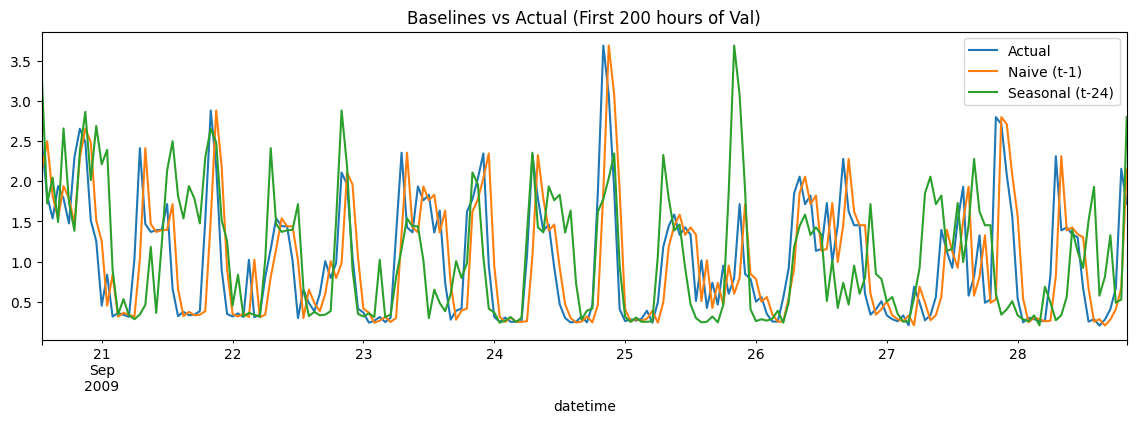

In [11]:
plt.figure(figsize=(14,4))
y_val_clean.iloc[:200].plot(label="Actual")
y_val_pred_naive.iloc[:200].plot(label="Naive (t-1)")
y_val_pred_seasonal.iloc[:200].plot(label="Seasonal (t-24)")
plt.title("Baselines vs Actual (First 200 hours of Val)")
plt.legend()
plt.show()